# Holt-Winters
The Holt-Winters model is a predictive/filtering model that helps estimate future data using three terms: a n average term, a trend term, and a seasonal term.
It only requires the variable itself over time, which is why it is so useful as few independent variables are needed. Only requiring past data is a pro and a con: think of reasons why!

<details>

<summary>Pros/Cons</summary>
Possible pros: reduced noise from useless IV, simplicity, less data collection<br><br>
Possible cons: captures correlation not causation, slower to react to changes, can't predict based on changes in true underlying variables
</details>

Now, we will go into the actual implementation and build up a logical foundation. We'll start by explaining the problem, and slowly build up to the full Holt-Winters model!

## Problem
One of the biggest issues that Holt-Winters is used for is in sales, specifically to find out how many units to produce. Let's say you invented this new technology, called an iPear. However, your issue is that iPears take a long time to make - up to 3 months!. Naturally, you'd want to know how many units you should make ahead of time.
> All of our data here at this stage is manufactured data. For this example, we'll be using random noise.

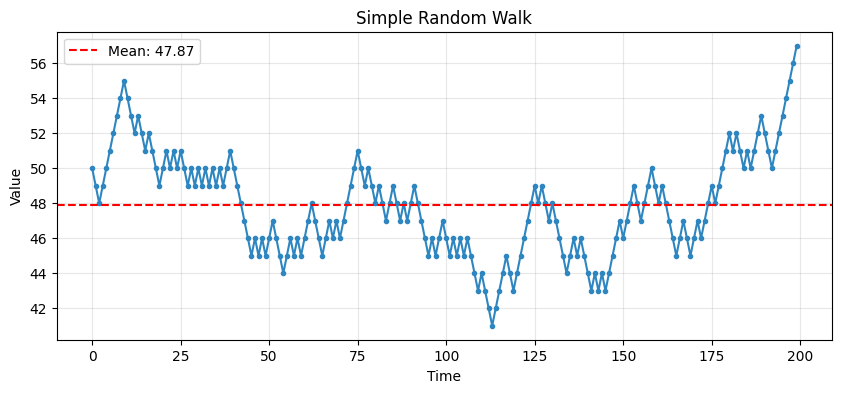

In [356]:
import random
import matplotlib.pyplot as plt

# 1. Setup
points = 200
current_value = 50  # Starting baseline
random.seed(67)
data = []

# 2. Generate Random Walk (+1 or -1)
for _ in range(points):
    data.append(current_value)
    # Roll the dice: if random number is 0, go down; if 1, go up
    step = 1 if random.randint(0, 1) == 1 else -1
    current_value += step
mean_value = sum(data) / len(data)
# 3. Plot
plt.figure(figsize=(10, 4))
plt.plot(data, color='#2E86C1', marker='o', markersize=3)
plt.title("Simple Random Walk")
plt.axhline(y=mean_value, color='red', linestyle='--', label=f"Mean: {mean_value:.2f}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Notice how ugly and horrible this data looks? However, it seems to hover around an *average*, and doesn't move quickly from one place to another - it seems semi-continuous. 
While your first thought may have been to use the average, the "stickiness" of this data, the fact that changes time to occur makes moving averages a lot easier.

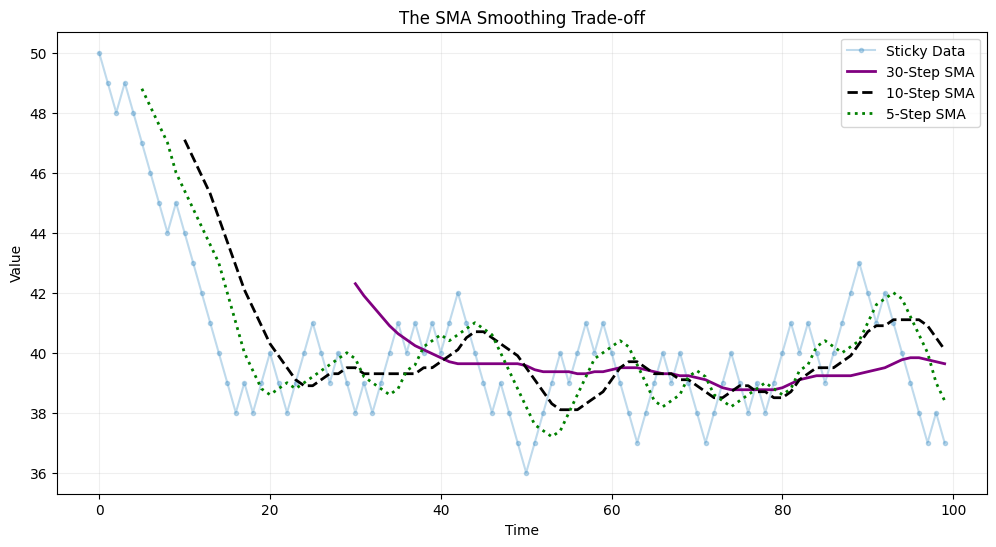

In [357]:
import random
import matplotlib.pyplot as plt

# 1. Setup Data
random.seed(42)
points = 100
current_value = 50 
data = []

# Generate the Random Walk (+1 or -1)
for _ in range(points):
    data.append(current_value)
    step = 1 if random.randint(0, 1) == 1 else -1
    current_value += step

# 2. Simple Moving Average Function (Fixed to be Honest)
def calculate_sma(data_list, window):
    # We need 'window' amount of points before we can make the first prediction
    sma_values = [None] * window 
    for i in range(window, len(data_list)):
        # Honest window: stops at i-1 (yesterday)
        window_data = data_list[i - window : i]
        sma_values.append(sum(window_data) / window)
    return sma_values

# 3. Calculate different "speeds" of SMA
sma_30 = calculate_sma(data, 30) # Purple: Slow/Smooth
sma_10 = calculate_sma(data, 10) # Black: Medium
sma_5  = calculate_sma(data, 5)  # Green: Fast/Responsive

# 4. Plotting everything
plt.figure(figsize=(12, 6))
plt.plot(data, color='#2E86C1', marker='o', markersize=3, alpha=0.3, label="Sticky Data")

plt.plot(sma_30, color='purple', linewidth=2, label="30-Step SMA")
plt.plot(sma_10, color='black',  linestyle='--', linewidth=2, label="10-Step SMA")
plt.plot(sma_5,  color='green',  linestyle=':', linewidth=2, label="5-Step SMA")

plt.title("The SMA Smoothing Trade-off")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

A moving average is simply an average that moves over time - you calculate it ONLY OVER a small portion of the time remaining.
<details>
<summary>What is the effect of more step time?</summary>
Increasing the step time increases how much time that this moving average looks over, making it "lag" more and not fitting to as much recent data as possible.
</details>
<br><br>
<details>
<summary>What are some weaknesses of this model?</summary>
At high step values, the values are too smoothed to make any predictions. Furthermore, there is always a lag, and not much of a prediction - you'll always be lagging behind until you can accept new data.
</details>

## SES
Due to these weakneses of the simple moving average, people invented a new way to track data closely: via simple exponential smoothing. The key goal of this method is to track data more closely, **weighing recent data more**. To get a sense of how this works, look at the graph below:

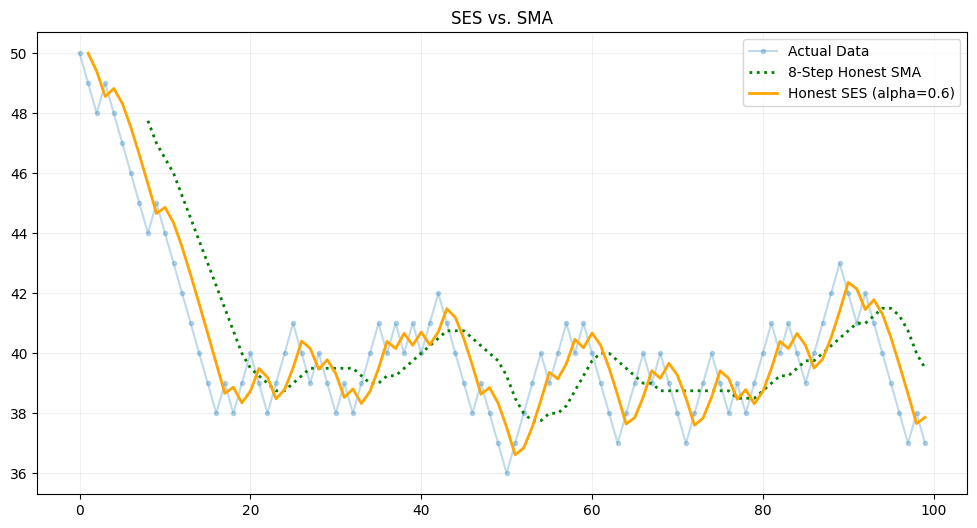

In [358]:
import random
import matplotlib.pyplot as plt

# 1. Setup Data (Random Walk)
random.seed(42)
points = 100
current_value = 50 
data = []
for _ in range(points):
    data.append(current_value)
    step = 1 if random.randint(0, 1) == 1 else -1
    current_value += step

# 2. Honest Simple Moving Average (SMA)
# To predict for index 'i', we take the average of indices (i-window) to (i-1)
window = 8
sma_honest = [None] * window # Cannot predict until we have a full window of past data
for i in range(window, len(data)):
    past_window = data[i - window : i] # Ends at i-1
    sma_honest.append(sum(past_window) / window)

# 3. Honest Simple Exponential Smoothing (SES)
alpha = 0.6
ses_honest = [None] # We can't forecast the first point
level = data[0]     # Initial 'state' using the first data point

for i in range(1, len(data)):
    # --- STEP 1: FORECAST (Using only past level) ---
    forecast_for_today = level
    ses_honest.append(forecast_for_today)
    
    # --- STEP 2: UPDATE (Now we see today's actual data) ---
    actual_today = data[i]
    level = (alpha * actual_today) + ((1 - alpha) * level)

# 4. Plotting
plt.figure(figsize=(12, 6))
plt.plot(data, color='#2E86C1', marker='o', markersize=3, alpha=0.3, label="Actual Data")
plt.plot(sma_honest, color='green', linestyle=':', linewidth=2, label=f"{window}-Step Honest SMA")
plt.plot(ses_honest, color='orange', linewidth=2, label=f"Honest SES (alpha={alpha})")

plt.title("SES vs. SMA")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Let's compare SMA and SES:
SMA weighs all points equally within the window:<br>
$$\hat{y}_{t+1}=\frac{y_t+y_{t-1}+y_{t-2}...y_{t-n}}{n-1}$$


However, we'd like to weigh recent data much more, hence the usage of SES. SES works based on the following formula, where $\alpha$ is a smoothing factor between 0 and 1.$$l_t = \alpha y_t + (1 - \alpha) l_{t-1}$$<details><summary>Why does this weigh recent data heavier? (Hint: Expand it out!)</summary>If we substitute the previous level ($l_{t-1}$) into the equation repeatedly, we get the expanded version:$$l_t = \alpha y_t + \alpha(1-\alpha)y_{t-1} + \alpha(1-\alpha)^2y_{t-2} + \alpha(1-\alpha)^3y_{t-3} + \dots$$Look at the weights:  
If $\alpha = 0.5$, the weights assigned to each data point look like this:
- Today ($y_t$): 0.5  
- Yesterday ($y_{t-1}$): 0.25  
- 2 Days Ago ($y_{t-2}$): 0.125  
- 3 Days Ago ($y_{t-3}$): 0.0625
<br><br>
Because $(1-\alpha)$ is a fraction, raising it to a higher power makes it smaller. Hence, simple exponential smoothing. Past data gets exponentially smaller and smoothed out over time.</details>

## Problem (again)
This SES is very good for data that tends to hover around the same average, but it also has some weaknesses. Take this data, for example, with iPears becoming very popular and sales soaring. Can you see why our SES model might struggle to capture this data?
> This data was created by taking some random walk noise, but applying a significant constant upwards trend to all of the data over time.

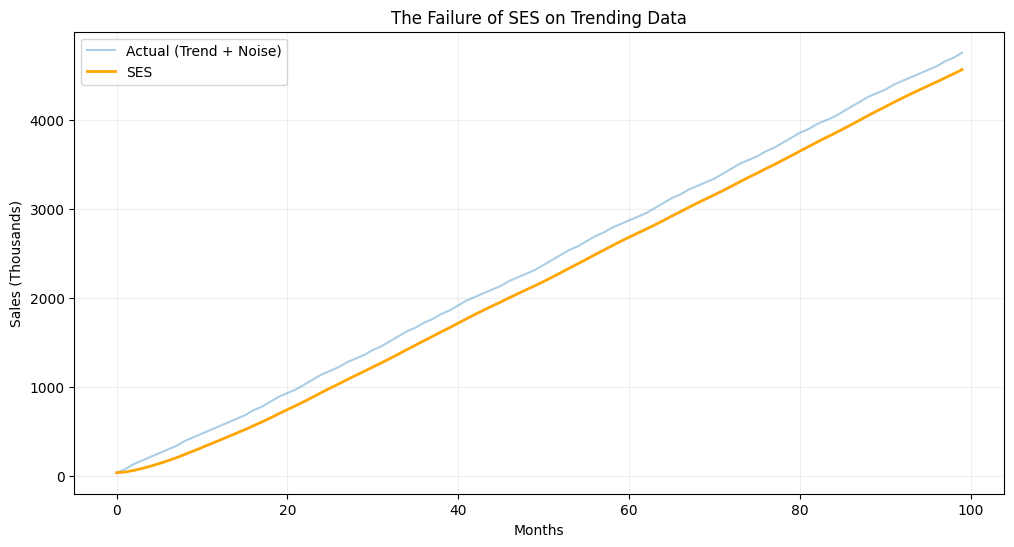

In [359]:
import random
import matplotlib.pyplot as plt

# 1. Setup
random.seed(42)
points = 100
current_level = 50 
slope = 50  # This is our Trend: the data grows by 0.5 every step
data_with_trend = []

# 2. Generate Trend + Sticky Noise
for t in range(points):
    # The value is the (Base Level) + (Cumulative Trend) + (Random Walk)
    trend_component = slope * t
    
    # Add the random walk logic from before
    step = 6 if random.randint(0, 1) == 1 else -9
    current_level += step
    
    data_with_trend.append(current_level + trend_component)

# 3. Simple Exponential Smoothing (SES) - To show it failing
alpha = 0.2
ses = [data_with_trend[0]]
for i in range(1, len(data_with_trend)):
    new_level = alpha * data_with_trend[i] + (1 - alpha) * ses[-1]
    ses.append(new_level)

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_trend, color='#2E86C1', alpha=0.4, label="Actual (Trend + Noise)")
plt.plot(ses, color='orange', linewidth=2, label="SES")

plt.title("The Failure of SES on Trending Data")
plt.xlabel("Months")
plt.ylabel("Sales (Thousands)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Due to the upwards trending nature of the data, the model lags behind, and isn't able to predict this trend. As of now, our model is still a "filter" or "smoothener" model, without any predictive power. To do so, we add a trend term to calculate the predicted trend over time.
$$l_t = \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1})$$
The Trend Update ($b_t$) The Trend equation calculates the current velocity. It looks at the difference between the new level and the old level to see how much we moved in a single step.$$b_t = \beta (l_t - l_{t-1}) + (1 - \beta)b_{t-1}$$
Beta is a new hyperparameter we have, and is how aggresive this trend parameter adjusts. Again, it's like simple exponential smoothing, but on the so-called "velocity" of the data. It smooths out the changes of the data, until you get an estimate for the change of the next step.

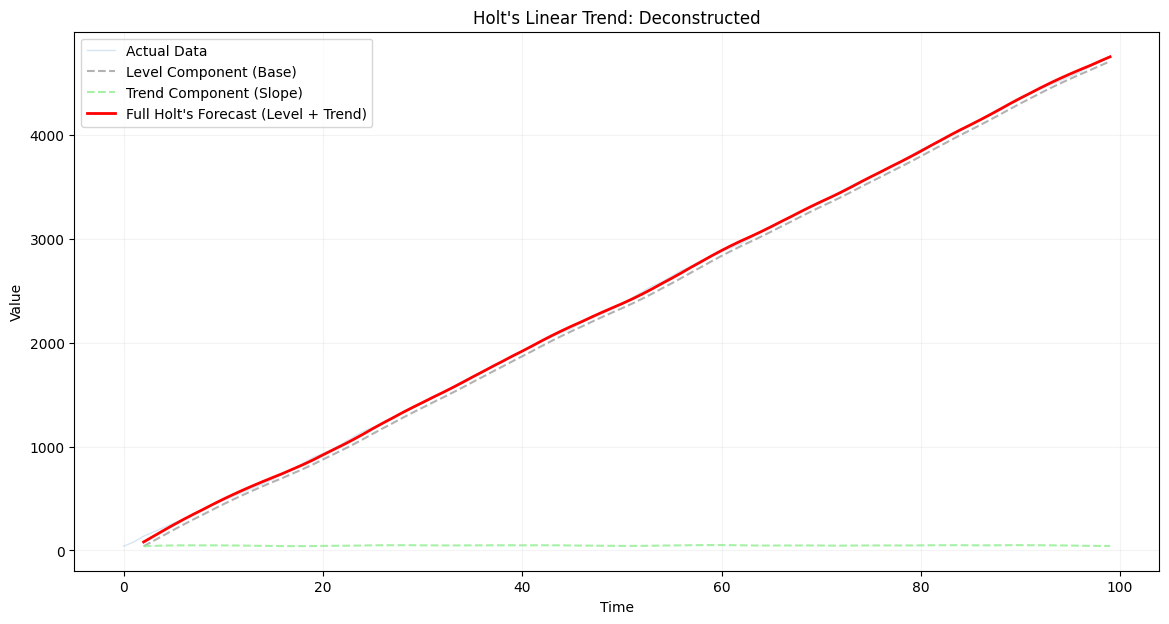

In [360]:
import matplotlib.pyplot as plt
import numpy as np
# 1. Setup Parameters
alpha = 0.2 
beta = 0.3   

level = data_with_trend[0]
trend = data_with_trend[1] - data_with_trend[0]

# Storage for the components
forecasts = [None, None] 
levels = [None, None]
trends = [None, None]

# 2. The Honest Loop
for t in range(2, len(data_with_trend)):
    # --- STEP 1: FORECAST (The sum of parts) ---
    prediction_for_today = level + trend
    forecasts.append(prediction_for_today)
    # Store components for visualization
    levels.append(level)
    trends.append(trend)
    
    # --- STEP 2: UPDATE ---
    actual_today = data_with_trend[t]
    last_level = level
    
    level = alpha * actual_today + (1 - alpha) * (level + trend)
    trend = beta * (level - last_level) + (1 - beta) * trend

# 3. Plotting
plt.figure(figsize=(14, 7))

# Actual Data
plt.plot(data_with_trend, color='#2E86C1', alpha=0.2, label="Actual Data", linewidth=1)

# The Components (The "Guts" of the model)
plt.plot(levels, color='gray', linestyle='--', alpha=0.6, label="Level Component (Base)")
plt.plot(trends, color='lightgreen', linestyle='--', alpha=0.8, label="Trend Component (Slope)")

# The Final Forecast
plt.plot(forecasts, color='red', linewidth=2, label="Full Holt's Forecast (Level + Trend)")

plt.title("Holt's Linear Trend: Deconstructed")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.15)
plt.show()

While the trend adjustment is relatively small, it's enough to fix the lag behind the real data. Think of it as the I in a PID controller, if you get the analogy - it helps fix small steady state error by correcting this small additional slope.
With this, we have the "Holt" component of Holt-Winters. Time for the Winters component!

## Problem (again, last time)
Another thing that might happen in sales is the impact of seasons - for example, iPears probably get very popular around Christmas and typical consumerist holidays. 
> This data was faked by creating a large spike every 10 days, along with an upward trend and random noise for SES and trend to do work.
Examine the data below, why is SES + Trend so horrible on this data?
It almost gets "surprised" every time there's that spike, even though it occurs regularly at predictable intervals. This is due to the fact that SES has "limited memory", where it doesn't actually hold exact values and just keeps a current running level. This kind of change is completely foreign - so guess what, we add a new term!


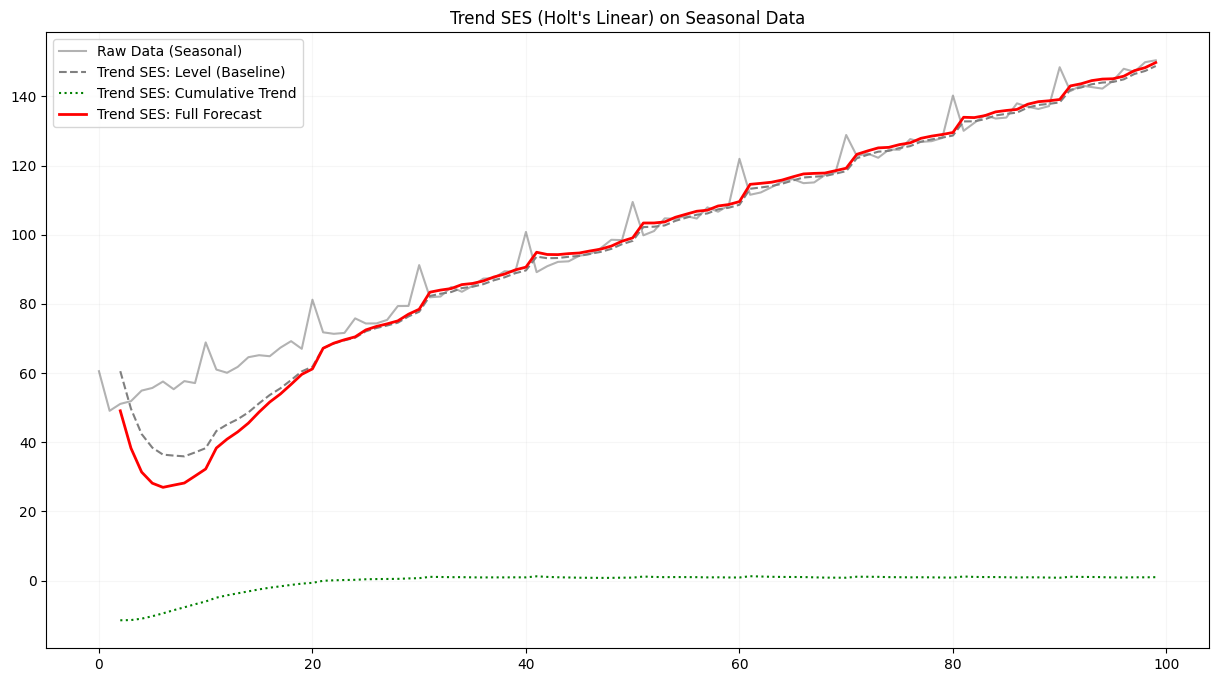

In [361]:
import random
import matplotlib.pyplot as plt

# 1. Generate Data (Trend + Seasonality + Noise)
random.seed(42)
L = 10 
points = 100
seasonal_data = []
for t in range(points):
    # Base (50) + Strong Trend (1*t) + Seasonality (10) + Noise
    val = 50 + (1 * t) + (10 if t % L == 0 else 0) + random.uniform(-2, 2)
    seasonal_data.append(val)

# 2. Parameters for Trend SES (Holt's Linear)
alpha = 0.3 # Level smoothing
beta = 0.1  # Trend smoothing

# 3. Initialization
level = seasonal_data[0]
trend = seasonal_data[1] - seasonal_data[0]

trend_ses_forecast = [None, None]
levels = [None, None]
cumulative_trend = [None, None]
running_trend_total = 0

# 4. Honest Trend SES Loop
for t in range(2, points):
    # FORECAST: Today = Yesterday's Level + Yesterday's Trend
    prediction = level + trend
    trend_ses_forecast.append(prediction)
    
    # Store components
    levels.append(level)
    running_trend_total = trend
    cumulative_trend.append(running_trend_total)
    
    # UPDATE with today's actual data
    actual_today = seasonal_data[t]
    last_level = level
    level = alpha * actual_today + (1 - alpha) * (level + trend)
    trend = beta * (level - last_level) + (1 - beta) * trend

# 5. Plotting
plt.figure(figsize=(15, 8))

# Raw Data
plt.plot(seasonal_data, color='#000000', alpha=0.3, label="Raw Data (Seasonal)")

# Holt's Linear Components
plt.plot(levels, color='gray', linestyle='--', label="Trend SES: Level (Baseline)")
plt.plot(cumulative_trend, color='green', linestyle=':', label="Trend SES: Cumulative Trend")
plt.plot(trend_ses_forecast, color='red', linewidth=2, label="Trend SES: Full Forecast")

plt.title("Trend SES (Holt's Linear) on Seasonal Data")
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

To add seasonality, we first must reduce the impact on SES by seasonal data, essentially telling it to "ignore" it's own prediction and to let the Seasonal term handle it.
$$l_t = \alpha (y_t - s_{t-L}) + (1 - \alpha)(l_{t-1} + b_{t-1})$$
The Seasonal Update ($s_t$). This is the "memory" equation. It looks at the current gap between the actual data and the level, then updates the specific "slot" in the seasonal buffer for that day of the cycle.$$s_t = \gamma (y_t - l_t) + (1 - \gamma)s_{t-L}$$
- $\gamma$ (Gamma): The seasonal smoothing factor ($0 < \gamma < 1$)
- $L$: The length of the season (e.g., $L=10$).
- $(y_t - l_t)$: The current "spike" height.
- $s_{t-L}$: What the spike height was exactly one cycle ago.
<br>
It only updates that specific slot in the buffer, only affecting that month/year/day. This allows for seasonal captures because only the seasonal buffer for $L$ units ago, 1 cycle ago, is used in the update. Hopefully, you understand how long a cycle is, so you can determine $L$ accurately (or perform grid search).
The final forecast adds all of these terms together.

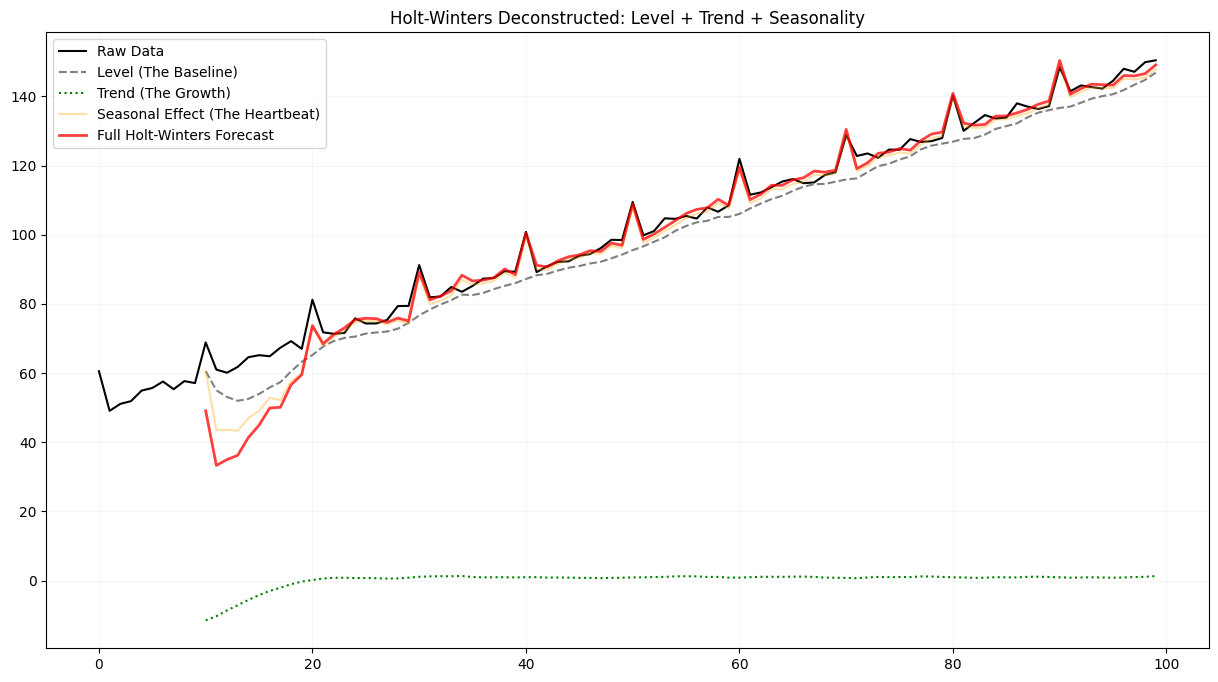

1.3882672339529862


In [362]:
import random
import matplotlib.pyplot as plt
# 2. Parameters & Initialization
alpha, beta, gamma = 0.3, 0.2, 0.6
level = seasonal_data[0]
trend = seasonal_data[1] - seasonal_data[0]
seasonals = [seasonal_data[i] - level for i in range(L)]

# Tracking lists
forecasts = [None] * L
levels = [None] * L
cumulative_trends = [None] * L
seasonal_outputs = [None] * L
running_trend = 0

# 3. The Honest Loop
for t in range(L, points):
    # FORECAST: Level + Trend + Seasonal
    prediction = (level + trend) + seasonals[t % L]
    forecasts.append(prediction)
    
    # Store Components
    levels.append(level)
    running_trend = trend
    cumulative_trends.append(running_trend)
    seasonal_outputs.append(seasonals[t % L])
    
    # UPDATE
    actual_today = seasonal_data[t]
    last_level = level
    level = alpha * (actual_today - seasonals[t % L]) + (1 - alpha) * (level + trend)
    trend = beta * (level - last_level) + (1 - beta) * trend
    seasonals[t % L] = gamma * (actual_today - level) + (1 - gamma) * seasonals[t % L]

# 4. Plotting
plt.figure(figsize=(15, 8))
plt.plot(seasonal_data, color='#000000', alpha=1.0, label="Raw Data")

# Component 1: The Average (Level)
plt.plot(levels, color='gray', linestyle='--', label="Level (The Baseline)")

# Component 2: The Trend (Cumulative)
plt.plot(cumulative_trends, color='green', linestyle=':', label="Trend (The Growth)")

# Component 3: The Seasonal (Individual spikes)
# We add this to the current Level so it sits on the graph properly
seasonal_viz = [ (l + s) if l is not None else None for l, s in zip(levels, seasonal_outputs)]
plt.plot(seasonal_viz, color='orange', alpha=0.35, label="Seasonal Effect (The Heartbeat)")

# Final Result
plt.plot(forecasts, color='red', linewidth=2, alpha=0.75,label="Full Holt-Winters Forecast")

plt.title("Holt-Winters Deconstructed: Level + Trend + Seasonality")
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()
print(trend)

While the trend component seems small, it's quite accurate - real trend is +1, and most of the work is done by SES and seasonal data.
Looking at an actual prediction, it looks to perform quite well! Seasonal and trend are both accounted for long term, and any sudden random changes can be accounted for by the SES portion (as we saw at the start.)

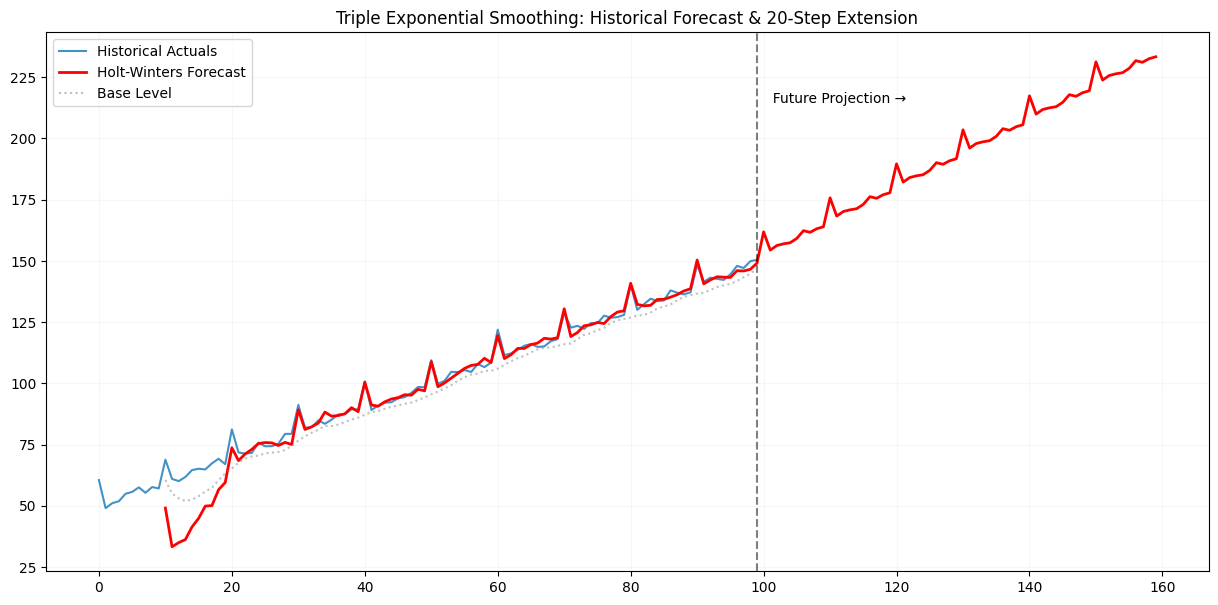

In [363]:
import random
import matplotlib.pyplot as plt

# 1. Setup Data (Trend + Seasonality + Noise)
random.seed(42)
L = 10 # Seasonal period (e.g., 10 days)
points = 100
future_steps = 60
data = []

for t in range(points):
    # Base (50) + Trend (0.5/step) + Seasonality (10 every L steps) + Noise
    val = 50 + (1 * t) + (10 if t % L == 0 else 0) + random.uniform(-2, 2)
    data.append(val)

# 2. Parameters (Alpha: Level, Beta: Trend, Gamma: Seasonality)
alpha, beta, gamma = 0.3, 0.2, 0.6

# 3. Initialization
level = data[0]
trend = data[1] - data[0]
# Initial seasonal buffer (first L points)
seasonals = [data[i] - level for i in range(L)]

# Tracking for plotting
history_forecasts = [None] * L
levels = [None] * L
cumulative_trends = [None] * L
running_trend = 0

# 4. The "Honest" Historical Loop
for t in range(L, points):
    # FORECAST for today (Before seeing data[t])
    # Level_prev + Trend_prev + Seasonal_prev_cycle
    prediction = (level + trend) + seasonals[t % L]
    history_forecasts.append(prediction)
    
    # Store components for visualization
    levels.append(level)
    running_trend += trend
    cumulative_trends.append(running_trend)
    
    # OBSERVE AND UPDATE
    actual_today = data[t]
    last_level = level
    
    # Update Level (De-seasonalized)
    level = alpha * (actual_today - seasonals[t % L]) + (1 - alpha) * (level + trend)
    # Update Trend (Velocity of Level)
    trend = beta * (level - last_level) + (1 - beta) * trend
    # Update Seasonal (Memory of this specific point in cycle)
    seasonals[t % L] = gamma * (actual_today - level) + (1 - gamma) * seasonals[t % L]

# 5. The 20-Step Future Prediction (No more 'actual' data)
future_forecasts = []
for m in range(1, future_steps + 1):
    # Find the correct seasonal index for the future
    seasonal_index = (points + m - 1) % L
    # Predict using last known state: Level + (m * Trend) + Seasonal_Buffer
    pred_future = level + (m * trend) + seasonals[seasonal_index]
    future_forecasts.append(pred_future)

# 6. Combine for Plotting
complete_forecast = history_forecasts + future_forecasts

# 7. Visualization
plt.figure(figsize=(15, 7))
plt.plot(data, color='#2E86C1', alpha=0.9, label="Historical Actuals")
plt.plot(range(len(complete_forecast)), complete_forecast, color='red', linewidth=2, label="Holt-Winters Forecast")

# Add visual markers
plt.axvline(x=points-1, color='black', linestyle='--', alpha=0.5)
plt.text(points, plt.ylim()[1]*0.9, '  Future Projection →', verticalalignment='top')
plt.plot(levels, color='gray', linestyle=':', alpha=0.5, label="Base Level")

plt.title("Triple Exponential Smoothing: Historical Forecast & 20-Step Extension")
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

# Summary
The POTD was predicting sales growth. Starting with simple moving average, we could smooth out the noise, but it created a lag for more recent data. To fix this, we moved to SES, which weighed recent data points more, but it struggled with constant growth and maintained a lag. To fix this, a trend term was added, creating the basic Holt Trend SES model. However, to account for seasonal changes in price, a final term was added to create the Holt-Winters model.<br><br>
The Holt-Winters model is as follows:<br>
The Level ($l_t$): The de-seasonalized baseline.$$l_t = \alpha (y_t - s_{t-L}) + (1 - \alpha)(l_{t-1} + b_{t-1})$$This tells us where the 'center' of the data is after stripping away the predictable pulse.
<br>
The Trend ($b_t$): The smoothed velocity.$$b_t = \beta (l_t - l_{t-1}) + (1 - \beta)b_{t-1}$$This tracks how fast that center is moving up or down.
<br>
The Seasonal ($s_t$): The recurring heartbeat.$$s_t = \gamma (y_t - l_t) + (1 - \gamma)s_{t-L}$$This remembers what the typical deviation is for this specific point in the cycle (e.g., every 10th step).
<br>
The Resulting Forecast:
When we want to look $m$ steps into the future, we simply combine these three forces:$$\hat{y}_{t+m} = \underbrace{l_t}_{\text{Where we are}} + \underbrace{m b_t}_{\text{Where we're going}} + \underbrace{s_{t-L+(m \pmod L)}}_{\text{The pulse we expect}}$$


## Strengths and Weaknesses
**Strengths**:
- Predictive capabilities for trend and seasonal data
- Only requires time series data as it's source of truth
- Decomposable, allows us to see which component is the driving force behind a behavior
**Weaknesses**
- Utilizes many "training" hyperparameters to tune the weights of each
- Reliance on $L$, knowledge of internal system dynamics to determine cycle time (or just run a t-test)
- Requires a significant amount of data to "get it going", to start creating predictions
- Does not incorporate other variables, essentially only using correlation and not causation.